In [3]:
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp
import pickle

import emcee
from multiprocess import Pool
from getdist import plots, MCSamples

%matplotlib ipympl

In [4]:
base_dir = '/home/nahue-ofi/'
# base_dir = '/home/nahue/'

def give_cl_cmb(ell, r=0, Alens=1.):
        
    power_spectrum = hp.read_cl(base_dir+'CMM-Pipeline/src/data/Cls_Planck2018_lensed_scalar.fits')[:,:4000]
    if Alens != 1.:
        power_spectrum[2] *= Alens
    if r:
        power_spectrum += r * hp.read_cl(base_dir+'CMM-Pipeline/src/data/Cls_Planck2018_unlensed_scalar_and_tensor_r1.fits')[:,:4000]
    return np.interp(ell, np.arange(1, 4001, 1), power_spectrum[2])

# with open(base_dir+'CMM-Pipeline/src/autospectrum_cmb_d0_100_143_planck_parametric_d0_two.pkl', 'rb') as f: #autospectrum_realistic_in_cmb_d1_s0_out_cmb_d1_parametric_d1_two #autospectrum_forecast_inCMBDustSync_outCMBDustSync_advancedparametric_d0_two
#     data1 = pickle.load(f)

# with open(base_dir+'CMM-Pipeline/src/autospectrum_cmb_d0_fullHFI_planck_parametric_d0_two.pkl', 'rb') as f: #autospectrum_realistic_in_cmb_d1_s0_out_cmb_d1_parametric_d1_two #autospectrum_forecast_inCMBDustSync_outCMBDustSync_advancedparametric_d0_two
#     data1 = pickle.load(f)
    
with open(base_dir+'CMM-Pipeline/src/autospectrum_cmbIO_d0IO_syncI_fullHFI_noiseless_different_cmbseeds_parametric_d0_two.pkl', 'rb') as f: #autospectrum_realistic_in_cmb_d1_s0_out_cmb_d1_parametric_d1_two #autospectrum_forecast_inCMBDustSync_outCMBDustSync_advancedparametric_d0_two
    data = pickle.load(f)

# with open(base_dir+'CMM-Pipeline/src/autospectrum_cmbseed1_50reals_nofg.pkl', 'rb') as f:
#     datanofg = pickle.load(f)

_f = data['ell'] * (data['ell'] + 1) / (2 * np.pi)

print(data.keys())
print(np.shape(data['DlBB_i']))
nreals = np.shape(data['DlBB_i'])[0]

dict_keys(['ell', 'DlBB_i', 'DlBB_i_res', 'DlBB_mean', 'DlBB_mean_res'])
(14, 2, 2, 16)


<function matplotlib.pyplot.tight_layout(*, pad: 'float' = 1.08, h_pad: 'float | None' = None, w_pad: 'float | None' = None, rect: 'tuple[float, float, float, float] | None' = None) -> 'None'>

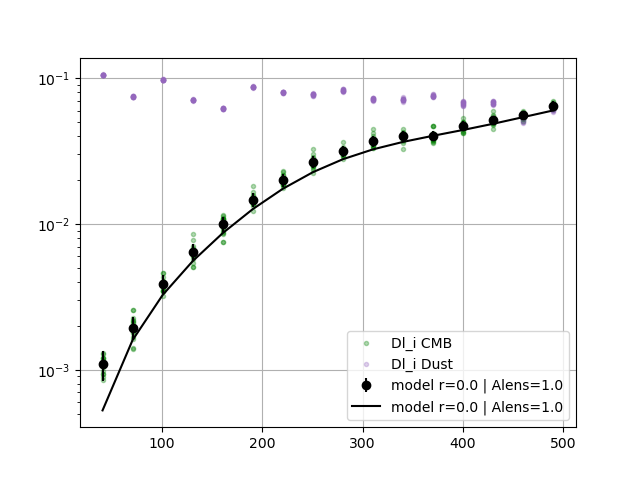

In [5]:
Alens = 1.
r = 0.

cosmic_variance_corrected = 2/(2*data['ell']+1)*1/(0.0145)*(1/30)*(np.mean(data['DlBB_i'][:,0,0,:],axis=0))**2

plt.figure()

for i in range(nreals):
    if i==0:
        plt.plot(data['ell'], data['DlBB_i'][i,0,0,:],'g.',alpha=0.3,label='Dl_i CMB')
        plt.plot(data['ell'], data['DlBB_i'][i,1,1,:],'C4.',alpha=0.3,label='Dl_i Dust')
        # plt.plot(data['ell'], data['DlBB_i_res'][i,0,0,:],'C4.',alpha=0.3,label='Dl_i_res')
        # plt.plot(data['ell'], data['DlBB_i'][i,0,0,:]-data['DlBB_i_res'][i,0,0,:],'C1.',alpha=0.3,label='Dl_i-Dl_res_i')
        # plt.plot(data['ell'], data['DlBB_i'][i,0,0,:]-np.mean(data['DlBB_i_res'][:,0,0,:],axis=0),'b.',alpha=0.3,label='Dl_i-Dl_mrm')
    plt.plot(data['ell'], data['DlBB_i'][i,0,0,:],'g.',alpha=0.3)
    plt.plot(data['ell'], data['DlBB_i'][i,1,1,:],'C4.',alpha=0.3)
    # plt.plot(data['ell'], data['DlBB_i_res'][i,0,0,:],'C4.',alpha=0.3)
    # plt.plot(data['ell'], data['DlBB_i'][i,0,0,:]-data['DlBB_i_res'][i,0,0,:],'C1.',alpha=0.3)
    # plt.plot(data['ell'], data['DlBB_i'][i,0,0,:]-np.mean(data['DlBB_i_res'][:,0,0,:],axis=0),'b.',alpha=0.3)

plt.errorbar( data['ell'], np.mean(data['DlBB_i'][:,0,0,:],axis=0), yerr = np.sqrt(2/(2*data['ell']+1)*1/(0.0145)*(1/30)*(np.mean(data['DlBB_i'][:,0,0,:],axis=0))**2), fmt='ok', label=f'model r={r} | Alens={Alens}' )
# plt.errorbar( data['ell'], np.mean(data['DlBB_i'][:,0,0,:],axis=0), fmt='g-o', label='mean(Dl_i)' )
# plt.errorbar( data['ell'], data['DlBB_mean'][0,0,:], fmt = 'k-o', label = 'Dl_meanmap' )
# plt.errorbar( data['ell'], data['DlBB_mean'][0,0,:]-data['DlBB_mean_res'][0,0,:], fmt='-o', label='Dl_mm - Dl_mrm',alpha=0.4 )
# plt.plot( data['ell'], np.mean(data['DlBB_i'][:,0,0,:]-data['DlBB_i_res'][:,0,0,:],axis=0),'C1-o',label='mean(Dl_i-Dl_res_i)' )
# plt.plot( data['ell'], np.mean(data['DlBB_i'][:,0,0,:]-np.mean(data['DlBB_i_res'][:,0,0,:],axis=0),axis=0),'b-x',label='mean(Dl_i-Dl_mrm)' )
plt.errorbar( data['ell'], _f * give_cl_cmb(data['ell'], r, Alens), fmt='-k', label=f'model r={r} | Alens={Alens}' )
# plt.errorbar( data['ell'], _f * give_cl_cmb(data['ell'], 0, 1), fmt='--k', label='model r=0 | A=1',zorder=10)

plt.yscale('log')
plt.grid()
plt.legend()
plt.tight_layout

# plt.figure()
# plt.suptitle('Spectra of the meanmap')
# plt.errorbar( data['ell'], data['DlBB_mean'][0,0,:], fmt = '-o', label = 'CMB-CMB' )
# plt.errorbar( data['ell'], data['DlBB_mean'][1,1,:], fmt = '-o', label = 'Dust-Dust' )
# plt.errorbar( data['ell'], data['DlBB_mean'][1,0,:], fmt = 'o', label = 'Dust-CMB' )
# plt.errorbar( data['ell'], - data['DlBB_mean'][1,0,:], fmt = 'o', label = '-(Dust-CMB)' )
# # plt.errorbar( data['ell'], data['DlBB_mean'][0,1,:], fmt = '-o', label = 'Dl_meanmap' )

# plt.yscale('log')
# plt.grid()
# plt.legend()
# plt.tight_layout

# plt.figure()
# plt.suptitle('Spectra of the unbiased maps')
# plt.errorbar( data['ell'], np.mean(data['DlBB_i'][:, 0, 0,:] - data['DlBB_i_res'][:, 0, 0,:],axis=0), fmt = '-o', label = 'CMB-CMB' )
# plt.errorbar( data['ell'], np.mean(data['DlBB_i'][:, 1, 1,:] - data['DlBB_i_res'][:, 1, 1,:],axis=0), fmt = '-o', label = 'Dust-Dust' )
# plt.errorbar( data['ell'], np.mean(data['DlBB_i'][:, 1, 0,:] - data['DlBB_i_res'][:, 1, 0,:],axis=0), fmt = 'o', label = 'Dust-CMB' )
# plt.errorbar( data['ell'], - np.mean(data['DlBB_i'][:, 1, 0,:] - data['DlBB_i_res'][:, 1, 0,:],axis=0), fmt = 'o', label = '-(Dust-CMB)' )
# # plt.errorbar( data['ell'], data['DlBB_mean'][0,1,:], fmt = '-o', label = 'Dl_meanmap' )

# plt.yscale('log')
# plt.grid()
# plt.legend()
# plt.tight_layout

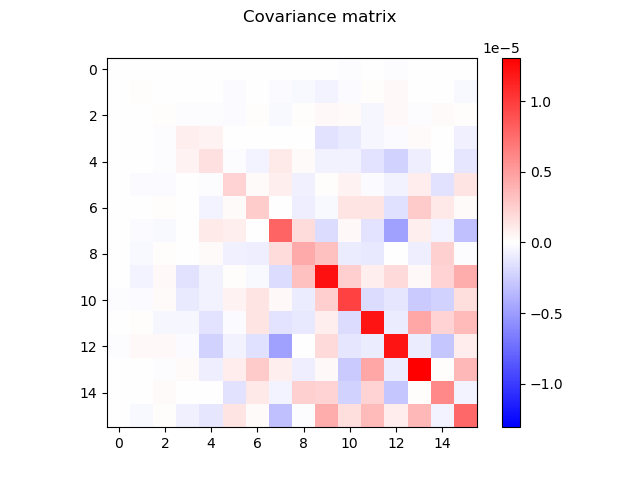

In [6]:
data_cc = data['DlBB_i'][:, 0, 0,:]#data['DlBB_i'][:, 0, 0,:] - data['DlBB_i_res'][:, 0, 0,:]#
data_dd = data['DlBB_i'][:, 1, 1,:]#data['DlBB_i'][:, 1, 1,:] - data['DlBB_i_res'][:, 1, 1,:]#
data_dc = data['DlBB_i'][:, 1, 0,:]#data['DlBB_i'][:, 1, 0,:] - data['DlBB_i_res'][:, 1, 0,:]#

data_for_cov = np.append(data_cc, data_dd,axis=1)
data_for_cov = np.append(data_for_cov, data_dc,axis=1)
# print(data_for_cov)
# cov_complete = np.cov(data_for_cov, rowvar=False)
cov_complete = np.cov(data_cc, rowvar=False)

plt.figure()

plt.suptitle('Covariance matrix')
vmax = np.max(np.abs(cov_complete[:, :]))
plt.imshow(cov_complete[:, :], vmin=-vmax, vmax=vmax, cmap='bwr')
plt.colorbar()

# plt.figure()
# plt.suptitle('Log Covariance matrix')
# plt.imshow(np.log(cov_complete[:, :]), cmap='bwr')
# plt.colorbar()

# plt.figure()
# plt.suptitle('Log Abs Covariance matrix')
# plt.imshow(np.log(np.abs(cov_complete[:, :])), cmap='bwr')
# plt.colorbar()

cov_inv = np.linalg.inv(cov_complete)

# plt.figure()

# plt.suptitle('Inverse covariance matrix')
# plt.imshow(cov_inv[:, :], cmap='bwr')#, vmin=-vmax, vmax=vmax, cmap='bwr')
# plt.colorbar()

# plt.figure()

# plt.suptitle('Inverse log covariance matrix')
# plt.imshow(np.log(cov_inv[:, :]), cmap='bwr')#, vmin=-vmax, vmax=vmax, cmap='bwr')
# plt.colorbar()

# plt.figure()

# plt.suptitle('Inverse log abs covariance matrix')
# plt.imshow(np.log(np.abs(cov_inv[:, :])), cmap='bwr')#, vmin=-vmax, vmax=vmax, cmap='bwr')
# plt.colorbar()

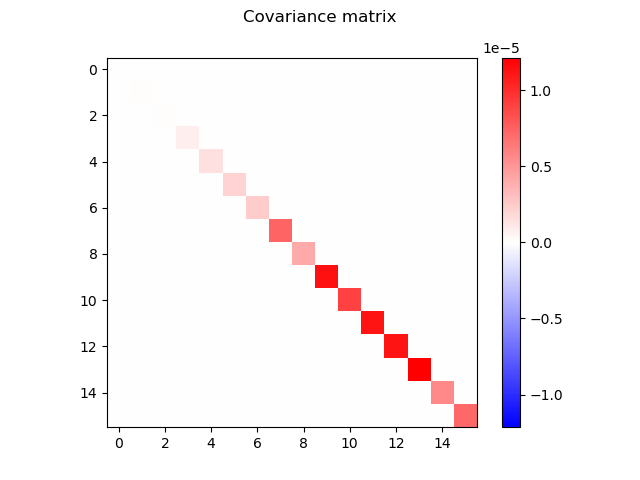

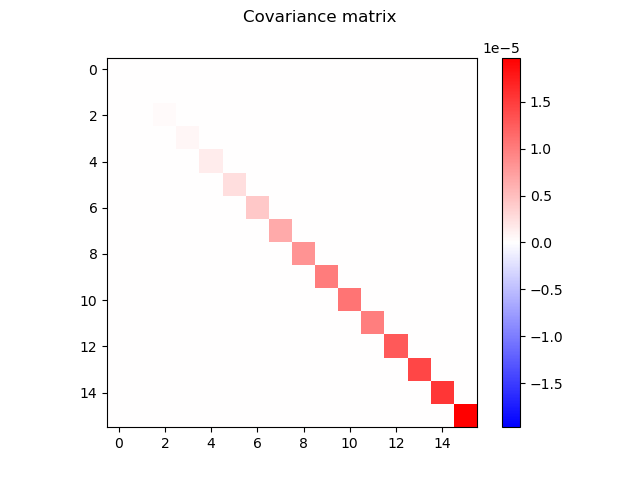

In [7]:
cov_cc_diag_1 = np.zeros((16,16))
np.fill_diagonal(cov_cc_diag_1, np.std(data['DlBB_i'][:,0,0,:], axis=0)**2)#data['DlBB_i'][:,0,0,:]-data['DlBB_i_res'][:,0,0,:]#

# cov_cc_diag_1_theo = np.zeros((16,16))
# np.fill_diagonal(cov_cc_diag_1, 2/(2*data['ell']+1)*1/(0.0145)*(1/30)*(np.mean(data['DlBB_i'][:,0,0,:],axis=0))**2)#data['DlBB_i'][:,0,0,:]-data['DlBB_i_res'][:,0,0,:]

# cov_dd_diag_1 = np.zeros((16,16))
# np.fill_diagonal(cov_dd_diag_1, np.std(data['DlBB_i'][:,1,1,:], axis=0)**2)#data['DlBB_i'][:,1,1,:]-data['DlBB_i_res'][:,1,1,:]#

# cov_dc_diag_1 = np.zeros((16,16))
# np.fill_diagonal(cov_dc_diag_1, np.std(data['DlBB_i'][:,1,0,:], axis=0)**2)#data['DlBB_i'][:,1,0,:]-data['DlBB_i_res'][:,1,0,:]#

# # cov_cc_dd_dc_diag = np.zeros((48,48))
# cov_cc_dd_dc_diag = np.zeros((16,16))

# cov_cc_dd_dc_diag[:16,:16] = cov_cc_diag_1
# # cov_cc_dd_dc_diag[16:32,16:32] = cov_dd_diag_1
# # cov_cc_dd_dc_diag[32:,32:] = cov_dc_diag_1

plt.figure()

plt.suptitle('Covariance matrix')
vmax = np.max(np.abs(cov_cc_diag_1[:, :]))
plt.imshow(cov_cc_diag_1[:, :], vmin=-vmax, vmax=vmax, cmap='bwr')
plt.colorbar()

# plt.figure()

# plt.suptitle('Log Covariance matrix')
# plt.imshow(np.log(cov_cc_dd_dc_diag[:, :]), cmap='bwr')
# plt.colorbar()

# plt.figure()
# plt.suptitle('Log Abs Covariance matrix')
# plt.imshow(np.log(np.abs(cov_cc_dd_dc_diag[:, :])), cmap='bwr')
# plt.colorbar()

# cov_inv = np.linalg.inv(cov_cc_dd_dc_diag)

# plt.figure()

# plt.suptitle('Inverse log covariance matrix')
# vmax = np.max(np.abs(cov_inv[:, :]))
# plt.imshow(np.log(cov_inv[:, :]), cmap='bwr')#, vmin=-vmax, vmax=vmax, cmap='bwr')
# plt.colorbar()

# plt.figure()

# plt.suptitle('Inverse log abs covariance matrix')
# vmax = np.max(np.abs(cov_inv[:, :]))
# plt.imshow(np.log(np.abs(cov_inv[:, :])), cmap='bwr')#, vmin=-vmax, vmax=vmax, cmap='bwr')
# plt.colorbar()

cov_cc_diag_1_theo = np.zeros((16,16))
np.fill_diagonal(cov_cc_diag_1_theo, 2/(2*data['ell']+1)*1/(0.0145)*(1/30)*(np.mean(data['DlBB_i'][:,0,0,:],axis=0))**2)
plt.figure()

plt.suptitle('Covariance matrix')
vmax = np.max(np.abs(cov_cc_diag_1_theo[:, :]))
plt.imshow(cov_cc_diag_1_theo[:, :], vmin=-vmax, vmax=vmax, cmap='bwr')
plt.colorbar()

In [12]:
print(np.std(data['DlBB_i'][:,0,0,:], axis=0))

[6.27650237e-05 4.89672555e-05 9.21537159e-05 1.19949651e-04
 1.18788378e-04 1.46075834e-04 1.44149400e-04 1.96572237e-04
 2.77460534e-04 2.86883415e-04 3.83318384e-04 5.09586267e-04
 5.21317791e-04 6.20074998e-04 6.30340522e-04 6.04256165e-04]


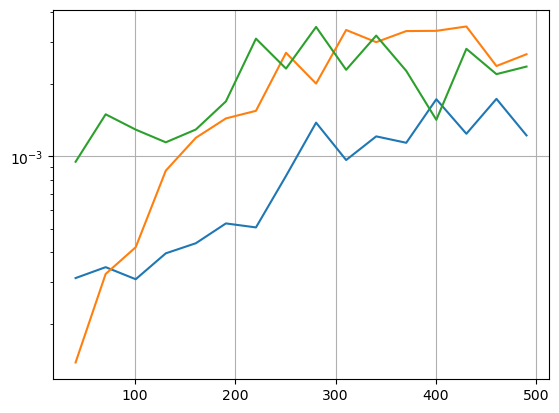

In [15]:
%matplotlib inline
plt.figure()
plt.plot(data['ell'],np.std(data['DlBB_i'][:,1,1,:], axis=0))
plt.plot(data['ell'],np.std(data['DlBB_i'][:,0,0,:], axis=0))
plt.plot(data['ell'],np.std(data['DlBB_i'][:,1,0,:], axis=0))
plt.yscale('log')
plt.grid()